In [2]:
def compute_f1_scores(pred_pt, gold_pt, verbose=True):
    """
    Function to compute F1 scores with pred and gold quads
    The input needs to be already processed
    """
    # number of true postive, gold standard, predictions
    n_tp, n_gold, n_pred = 0, 0, 0

    for i in range(len(pred_pt)):
        n_gold += len(gold_pt[i])
        n_pred += len(pred_pt[i])

        for t in pred_pt[i]:
            if t in gold_pt[i]:
                n_tp += 1

    if verbose:
        print(
            f"number of gold spans: {n_gold}, predicted spans: {n_pred}, hit: {n_tp}"
        )

    precision = float(n_tp) / float(n_pred) if n_pred != 0 else 0
    recall = float(n_tp) / float(n_gold) if n_gold != 0 else 0
    f1 = 2 * precision * recall / (
        precision + recall) if precision != 0 or recall != 0 else 0
    scores = {
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'accuracy': n_tp / n_gold * 100
    }

    return scores

def dict_to_list(aspect_list, sentiment_elements):
    tuples = []
    for aspect in aspect_list:
        tuple = []
        for key in sentiment_elements:
            tuple.append(aspect[key])
        tuples.append(tuple)
    return tuples

In [3]:
import json
import numpy as np
f1_scores_all = {}
model = "gemma3_27b"
seeds = ["seed_0", "seed_1", "seed_42", "seed_43", "seed_44"]
modes = ["random", "rag"]
n_prompts = 0

for mode in modes:
  for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
    for task in ["tasd", "acd", "asqp"]:
        f1_scores = []
        k_list = []
        
        for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]:
            f1_scores_per_seed = []
            
            if mode == "random":
                pred_phrase = "predictions_random"
            else:
                pred_phrase = "predictions"
            
            # Statistische Analyse: Vergleich RAG vs Random für jede Task-Dataset-Kombination
            for seed in seeds:
                try:
                    with open(f"./{pred_phrase}/{seed}/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                       data = json.load(f)
                       n_prompts += len(data)
                except FileNotFoundError:
                    print("not found")
                    continue
                
                sentiment_elements = list(data[0]["gold"][0].keys())
                
                preds = [dict_to_list(example["predicted"], sentiment_elements) for example in data]
                golds = [dict_to_list(example["gold"], sentiment_elements) for example in data]

                scores = compute_f1_scores(preds, golds, verbose=False)
                f1_scores_per_seed.append(scores["f1"])
                
            # print(f"{dataset_name}_{task}_{mode}_k{k}: {f1_scores_per_seed}")
            
            # Nur fortfahren wenn wir Daten für mindestens einen Seed haben
            if f1_scores_per_seed:
                # Mittelwert über alle verfügbaren Seeds
                avg_f1 = np.mean(f1_scores_per_seed)
                f1_scores.append(avg_f1)
                k_list.append(k)

        f1_scores_all[f"{dataset_name}_{task}_{mode}"] = {"f1": f1_scores, "k": k_list}

In [4]:
n_prompts

580690

In [5]:
# Statistische Analyse: Vergleich RAG vs Random für jede Task-Dataset-Kombination
from scipy.stats import shapiro, ttest_rel, wilcoxon
from statsmodels.stats.multitest import multipletests

# Sammle p-Werte für alle Task-Dataset-Kombinationen
p_values = []
task_dataset_pairs = []
test_types = []

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

for task in tasks:
    for dataset in datasets:
        key_rag = f"{dataset}_{task}_rag"
        key_random = f"{dataset}_{task}_random"
        
        if key_rag in f1_scores_all and key_random in f1_scores_all:
            f1_rag = f1_scores_all[key_rag]["f1"]
            f1_random = f1_scores_all[key_random]["f1"]
            print(f1_rag)
            print(f1_random)
            
            # Prüfe Normalverteilung
            _, p_norm_rag = shapiro(f1_rag)
            _, p_norm_random = shapiro(f1_random)
            
            if p_norm_rag > 0.05 and p_norm_random > 0.05:
                # Paired t-Test
                if len(f1_rag) != len(f1_random):
                    min_len = min(len(f1_rag), len(f1_random))
                    f1_rag = f1_rag[:min_len]
                    f1_random = f1_random[:min_len]
                _, p_value = ttest_rel(f1_rag, f1_random)
                test_type = "t-test"
            else:
                # Wilcoxon signed-rank test
                try:
                    _, p_value = wilcoxon(f1_rag, f1_random)
                    test_type = "Wilcoxon"
                except ValueError:
                    # All differences are zero
                    p_value = 1.0
                    test_type = "No difference"
            
            p_values.append(p_value)
            task_dataset_pairs.append((task, dataset))
            test_types.append(test_type)
            
            print(f"{task.upper()}-{dataset.capitalize()}: {test_type}, p={p_value:.4f}")

# print(f"\nAnzahl Tests: {len(p_values)}")

# Holm-Bonferroni Korrektur
rejected, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

# print(f"\nHolm-Bonferroni Korrektur (α = 0.05):")
# print(f"Anzahl signifikanter Tests: {sum(rejected)}")

# for i, (task, dataset) in enumerate(task_dataset_pairs):
#     sig_marker = "***" if rejected[i] else "n.s."
#     print(f"{task.upper()}-{dataset.capitalize()}: p_raw={p_values[i]:.4f}, p_adj={p_corrected[i]:.4f}, {test_types[i]} {sig_marker}")

[83.70073060201213, 83.64831810011643, 83.62782545919865, 83.68078789938713, 83.51195193602427, 83.99779549012212, 84.5444599314749, 84.4494135024989, 84.83588912762382, 84.69778023379403, 84.07772131722733]
[81.09855373402756, 80.72510192053555, 81.6374816119066, 81.68610764870381, 81.47338501819566, 80.98955003580723, 81.68169164183881, 81.91954749843583, 81.0213615682788, 81.30801276786244, 80.6582836373819]
ACD-Rest16: t-test, p=0.0000
[83.58793187734511, 83.7248623307667, 84.55717476776401, 84.44922840923542, 84.60144001466897, 83.75043915683163, 84.52299416926817, 84.37986717108723, 84.38679071319503, 84.6067965929723, 84.3420128490545]
[81.26584281718624, 81.13425499036202, 80.89210346363072, 81.35325859860578, 81.6073835230413, 81.73851893709742, 82.03121640923511, 80.47346197883861, 81.34839825847456, 80.31848952553756, 81.92124218490038]
ACD-Flightabsa: Wilcoxon, p=0.0010
[53.846243098007825, 54.626042910242575, 54.7920509849062, 54.42332025344975, 53.80726583861383, 54.82462

In [6]:
# Extract statistical results for visualization
statistical_info = {}

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

for i, (task, dataset) in enumerate(task_dataset_pairs):
    statistical_info[(task, dataset)] = (test_types[i], p_corrected[i], rejected[i])

print("Statistical information for visualization:")
for key, (test_type, p_adj, significant) in statistical_info.items():
    task, dataset = key
    sig_symbol = "***" if significant else "n.s."
    print(f"{task.upper()}-{dataset.capitalize()}: {test_type}, p_adj={p_adj:.4f} {sig_symbol}")

Statistical information for visualization:
ACD-Rest16: t-test, p_adj=0.0000 ***
ACD-Flightabsa: Wilcoxon, p_adj=0.0049 ***
ACD-Coursera: t-test, p_adj=0.0000 ***
ACD-Hotels: t-test, p_adj=0.0000 ***
TASD-Rest16: t-test, p_adj=0.0000 ***
TASD-Flightabsa: t-test, p_adj=0.0000 ***
TASD-Coursera: Wilcoxon, p_adj=0.0049 ***
TASD-Hotels: Wilcoxon, p_adj=0.0049 ***
ASQP-Rest16: Wilcoxon, p_adj=0.0049 ***
ASQP-Flightabsa: Wilcoxon, p_adj=0.0049 ***
ASQP-Coursera: t-test, p_adj=0.0000 ***
ASQP-Hotels: t-test, p_adj=0.0000 ***


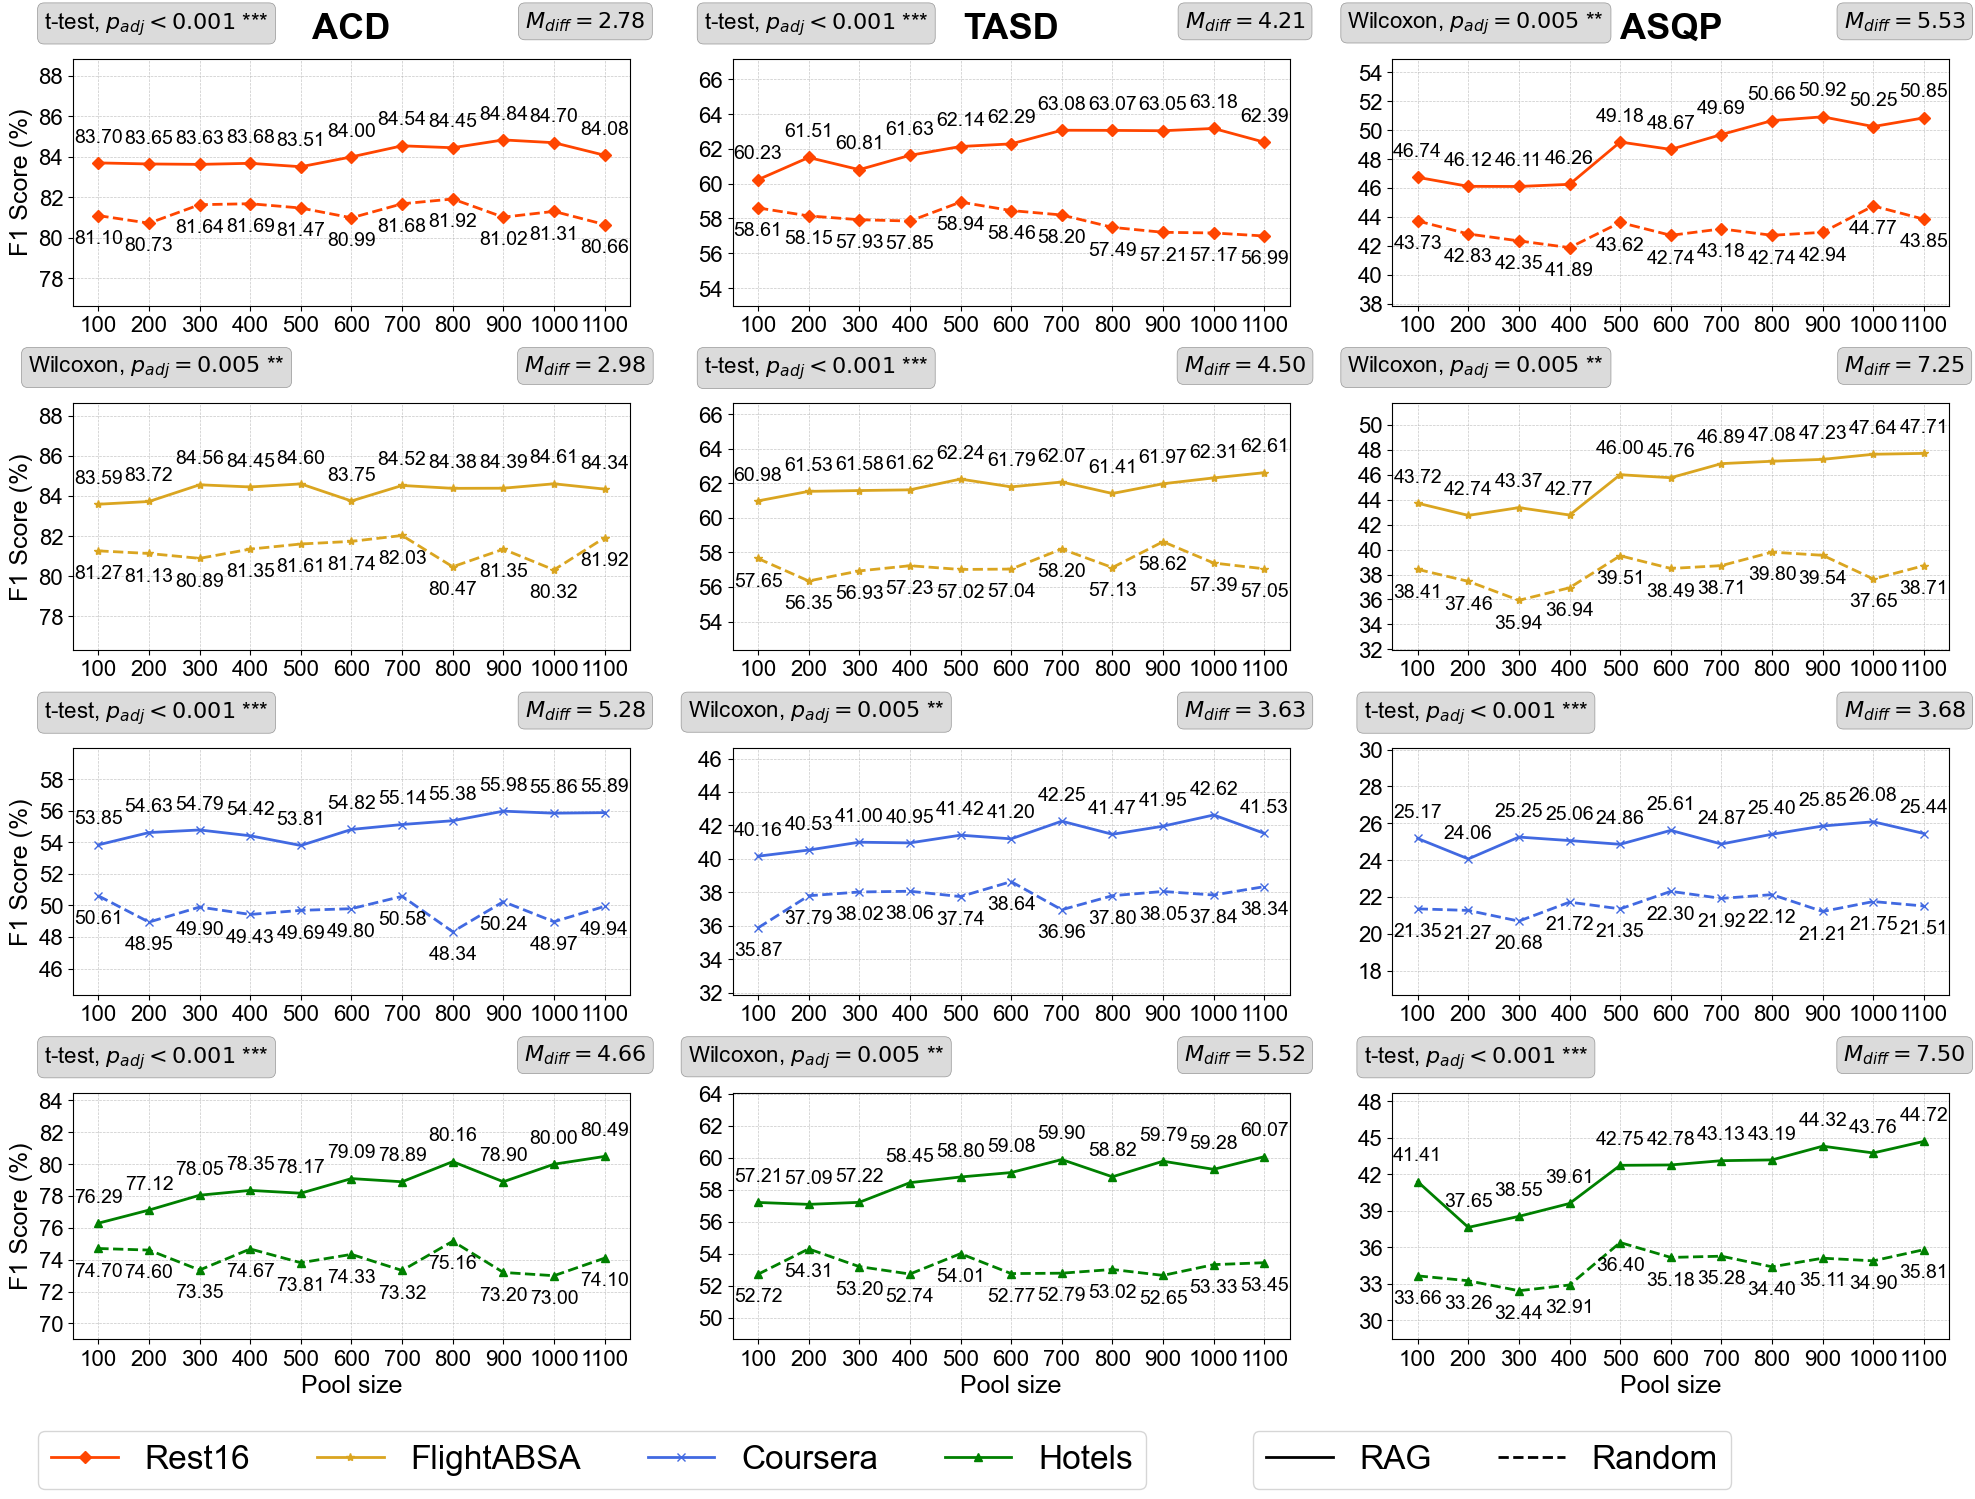

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Set a professional style with Arial font
plt.style.use('default')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
})

fig, axes = plt.subplots(4, 3, figsize=(20, 15))

tasks = ["acd", "tasd", "asqp"]
datasets = ["rest16", "flightabsa", "coursera", "hotels"]

# Define proper display names for datasets
dataset_display_names = {
    "rest16": "Rest16",
    "flightabsa": "FlightABSA", 
    "coursera": "Coursera",
    "hotels": "Hotels"
}

# Define colors and line styles for better distinction
colors = ['orangered', 'goldenrod', 'royalblue', 'green']  # Custom colors for datasets
line_styles = ['-', '--', '-.', ':']

# Define markers for each dataset
markers = {
    "rest16": 'D',      # diamond
    "flightabsa": '*',  # star
    "hotels": '^',      # triangle
    "coursera": 'x'     # x
}

# Calculate average differences between RAG and Random for each task-dataset combination
diff_info = {}
for i, task in enumerate(tasks):
    for j, dataset in enumerate(datasets):
        key_rag = f"{dataset}_{task}_rag"
        key_random = f"{dataset}_{task}_random"
        
        if key_rag in f1_scores_all and key_random in f1_scores_all:
            f1_rag = f1_scores_all[key_rag]["f1"]
            f1_random = f1_scores_all[key_random]["f1"]
            
            # Calculate mean difference (RAG - Random)
            if len(f1_rag) > 0 and len(f1_random) > 0:
                min_len = min(len(f1_rag), len(f1_random))
                diff = np.mean(f1_rag[:min_len]) - np.mean(f1_random[:min_len])
                diff_info[(task, dataset)] = diff

for i, task in enumerate(tasks):
    for j, dataset in enumerate(datasets):
        ax = axes[j, i]
        key_rag = f"{dataset}_{task}_rag"
        key_random = f"{dataset}_{task}_random"
        label = dataset_display_names[dataset]
        marker = markers[dataset]
        
        # Collect all y-values to determine y-axis limits
        all_y_values = []
        
        # Add statistical test information at the top of each subplot
        if (task, dataset) in statistical_info:
            test_type, p_adj, significant = statistical_info[(task, dataset)]
            if p_adj <= 0.001:
                sig_symbol = "***"
            elif p_adj <= 0.01:
                sig_symbol = "**"
            elif p_adj <= 0.05:
                sig_symbol = "*"
            else:
                sig_symbol = ""
            
            # Format p-value scientifically if very small
            if p_adj < 0.001:
                p_text = r"$p_{adj} < 0.001$"
            elif p_adj < 0.01:
                p_text = rf"$p_{{adj}} = {p_adj:.3f}$"
            else:
                p_text = rf"$p_{{adj}} = {p_adj:.3f}$"
            
            test_info = f"{test_type}, {p_text} {sig_symbol}"
            ax.text(0.15, 1.2, test_info, transform=ax.transAxes, 
                   fontsize=16, ha='center', va='top', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8,
                            edgecolor='gray', linewidth=0.5))
        
        # Add M_diff information in a grey box horizontally, right of the statistical test box
        if (task, dataset) in diff_info:
            m_diff = diff_info[(task, dataset)]
            diff_text = rf"$M_{{diff}} = {m_diff:.2f}$"
            ax.text(0.92, 1.2, diff_text, transform=ax.transAxes, 
                   fontsize=16, ha='center', va='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8,
                            edgecolor='gray', linewidth=0.5))
        
        # Plot RAG line
        if key_rag in f1_scores_all and "f1" in f1_scores_all[key_rag] and len(f1_scores_all[key_rag]["f1"]) > 0:
            k_list = f1_scores_all[key_rag]["k"]
            f1_list = f1_scores_all[key_rag]["f1"]
            all_y_values.extend(f1_list)
            ax.plot(k_list, f1_list, label=label, color=colors[j], linestyle='-', linewidth=2, marker=marker, markersize=6)
            # Annotate F1 values
            for x, y in zip(k_list, f1_list):
                ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,15), ha='center', fontsize=14)
        
        # Plot Random points
        if key_random in f1_scores_all and "f1" in f1_scores_all[key_random] and len(f1_scores_all[key_random]["f1"]) > 0:
            k_list_r = f1_scores_all[key_random]["k"]
            f1_list_r = f1_scores_all[key_random]["f1"]
            all_y_values.extend(f1_list_r)
            ax.plot(k_list_r, f1_list_r, color=colors[j], linestyle='--', linewidth=2, marker=marker, markersize=6)  # Dashed line for Random
            # Annotate F1 values
            for x, y in zip(k_list_r, f1_list_r):
                ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,-20), ha='center', fontsize=14)
        
        # Set y-axis limits with +1/-1 padding
        if all_y_values:
            y_min = min(all_y_values) - 4
            y_max = max(all_y_values) + 4
            ax.set_ylim(y_min, y_max)
            
            # Set y-axis ticks to integers only
            from matplotlib.ticker import MaxNLocator
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        # Set ticks for x-axis
        ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1])
        ax.set_xticklabels([f'{int(x * 1000)}' for x in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]])

        # Add grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        
        # Titles and labels
        if j == 0:
            ax.set_title(f'{task.upper()}', fontsize=26, fontweight='bold', y=1.05)
        if i == 0:
            ax.set_ylabel(f'F1 Score (%)', fontsize=18)
        if j == 3:
            ax.set_xlabel('Pool size', fontsize=18)
        
        # Increase tick label size
        ax.tick_params(axis='both', labelsize=16)

# Collect handles and labels for common legend
handles, labels = [], []
for ax in axes.flatten():
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates
unique_labels = list(dict.fromkeys(labels))  # Preserve order
unique_labels = ["Rest16", "FlightABSA", "Coursera", "Hotels"]
unique_handles = [handles[labels.index(label)] for label in unique_labels if label in labels]

# Add legend for line styles (RAG vs Random)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='RAG'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='Random')
]

# Main legend for datasets
fig.legend(unique_handles, unique_labels, loc='lower center', ncol=4, fontsize=24, bbox_to_anchor=(0.3, -0.01))

# Secondary legend for line styles
fig.legend(legend_elements, ['RAG', 'Random'], loc='lower center', ncol=2, fontsize=24, bbox_to_anchor=(0.75, -0.01))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig("performance_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
times_all = {}
modes = ["random", "rag"]
for mode in modes:
    for dataset_name in ["rest16", "flightabsa", "coursera", "hotels"]:
        for task in ["tasd", "acd", "asqp"]:
            for k in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]:
                
                if mode == "random":
                  pred_phrase = "predictions_random"
                else:
                  pred_phrase = "predictions"
                try:
                    with open(f"./{pred_phrase}/seed_0/{task}/{model}/{k}/{dataset_name}/predictions.json", 'r') as f:
                       data = json.load(f)
                except FileNotFoundError:
                    data = []
                
                times = [example["time"] for example in data]
                times_all[f"{dataset_name}_{task}_{mode}_{k}"] = np.mean(times)
            

In [9]:
import pandas as pd

# Create a list to hold the data
data = []
modes = ["random", "rag"]
k_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

for mode in modes:
    for task in tasks:
        for k in k_values:
            for dataset in datasets:
                key = f"{dataset}_{task}_{mode}_{k}"
                if key in times_all and not np.isnan(times_all[key]):
                    data.append({"task": task.upper(), "k": int(k * 1000), "dataset": dataset.capitalize(), "mode": mode.capitalize(), "time": times_all[key]})

# Create DataFrame
df_times = pd.DataFrame(data)

# Calculate average time per task, k, and mode over all datasets
df_avg = df_times.groupby(['task', 'k', 'mode'])['time'].mean().reset_index()

# Pivot the DataFrame
df_pivot = df_avg.pivot(index='k', columns=['task', 'mode'], values='time')

# Sort columns
df_pivot = df_pivot.sort_index(axis=1)

# display ACD, TASD and then ASQP for better readability
df_pivot = df_pivot.reindex(columns=['ACD', 'TASD', 'ASQP'], level=0)

# Calculate average prediction duration across all k values for each task-mode combination
avg_row = df_pivot.mean(axis=0).to_frame().T
avg_row.index = ['AVG']

# Append the average row to the pivot table
df_pivot = pd.concat([df_pivot, avg_row])

# Display the pivoted DataFrame
df_pivot

task       ACD                TASD                ASQP          
mode       Rag    Random       Rag    Random       Rag    Random
100   0.816075  0.850869  1.291522  1.239872  1.708251  1.622494
200   0.847844  0.852375  1.290779  1.203570  1.723317  1.626499
300   0.846259  0.870640  1.290624  1.210830  1.735816  1.641772
400   0.861861  0.856032  1.298397  1.220732  1.742694  1.621512
500   0.858165  0.867167  1.313773  1.220479  1.742529  1.646691
600   0.867519  0.851877  1.307770  1.218843  1.744769  1.629775
700   0.863592  0.884163  1.311165  1.210494  1.739000  1.639598
800   0.865091  0.871648  1.320443  1.210209  1.755218  1.638064
900   0.868329  0.864092  1.321620  1.204458  1.759385  1.635189
1000  0.871895  0.855705  1.310002  1.201889  1.745424  1.636265
1100  0.866271  0.858893  1.295558  1.198883  1.755679  1.617204
AVG   0.857537  0.862133  1.304696  1.212751  1.741098  1.632278

In [10]:
with open('performance_latex/muster_time.txt', 'r') as f:
    content = f.read()

for row in df_pivot.itertuples(index=False):
    for value in row:
        if isinstance(value, (float, np.floating)):
            if np.isnan(value):
               rep = "n.a."
            else:
               rep = f"{value:.3f}"
        else:
            rep = str(value)
        content = content.replace("xxxx", rep, 1)

with open('performance_latex/out_time.txt', 'w') as f:
    f.write(content)